Modelo de clasificación de imágenes
===================================

## Introducción

La clasificación de objetos es la tarea por la cual un modelo de aprendizaje automático asigna una o varias etiquetas a diferentes imágenes dependiendo del contenido de la misma. Esta tarea se volvió muy popular en 2012 en el contexto de aprendizaje automático ya que fué la primera tarea en alcanzar una performance sustancialmente mayor que con técnicas clásicas. 

Desde aquel entonces, el progreso en este campo ha sido tan grande que hoy en día disponemos de modelos de aprendizaje automático con performance superiores a las de un humano. Un ejemplo clásico es el de clasificación de razas de perror donde los modelos alcanzan a distinguir razas que resultan imposibles distinguir para incluso personas altamente experimentadas en esto.

### Preparación del ambiente

Intalamos las librerias necesarias

In [ ]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/docs/vision/tasks/classification/code/cnn_class.txt \
    --quiet --no-clobber
!pip install -r cnn_class.txt --quiet

In [1]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.5 MB/s eta 0:00:00


### Sobre el conjunto de datos de este ejemplo

Para ejemplificar esta técnica utilizaremos un conjunto de datos muy popular llamado CIFAR-10. CIFAR-10 es un conjunto de datos que consiste en 60.000 imagenes a color de 32x32 agrupadas en 10 clases, con 6000 imagenes cada una. Hay alrededor de 50000 imagenes para entrenamiento y 10000 para testing.

Las categorias son:
 - airplane
 - automobile
 - bird
 - cat
 - deer
 - dog
 - frog
 - horse
 - ship
 - truck

Podemos cargar este conjunto de datos facilmente utilizando `tensorflow-datasets`:

In [2]:
from datasets import load_dataset

train_ds, test_ds = load_dataset('cifar10', split=['train', 'test'])

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:325: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [4]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 45000
})

In [5]:
train_ds.features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

Veamos algunos ejemplos:

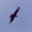

In [6]:
train_ds[0]['img']

## Construcción de una red neuronal convolucional

Antes de comenzar necesitaremos verificar que tenemos el runtime correcto en nuestro ambiente. Esta tarea se beneficiará mucho de una GPU.

In [7]:
import torch
print("GPUs disponibles: ", torch.cuda.device_count())

GPUs disponibles:  1


### Preprocesamiento

#### Tamaño y cantidad de parches

Los transformers esperan recibir cada imagen con una resolución específica y una cantidad de parches particular. Esta tarea se puede realizar utilizando el concepto de `processor` en `transformers`. 

Este tipo de components preprocesan los datos antes de ser enviados al modelo que los procesará. En este caso, utilizaremos el `processor` associado con un modelo en particular, `google/vit-base-patch16-224-in21k`. Notar como en el nombre está codificado el tamaño de los parches (16x16) y la resolución de las imágenes (224x224).

In [8]:
from transformers import ViTImageProcessor  

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [9]:
def process_example(example):
    inputs = processor(example['img'], return_tensors='pt')
    inputs['labels'] = example['label']

    return inputs

In [10]:
process_example(train_ds[0])

{'pixel_values': tensor([[[[0.2314, 0.2314, 0.2314,  ..., 0.1216, 0.1216, 0.1216],
          [0.2314, 0.2314, 0.2314,  ..., 0.1216, 0.1216, 0.1216],
          [0.2314, 0.2314, 0.2314,  ..., 0.1216, 0.1216, 0.1216],
          ...,
          [0.0275, 0.0275, 0.0275,  ..., 0.0745, 0.0745, 0.0745],
          [0.0275, 0.0275, 0.0275,  ..., 0.0745, 0.0745, 0.0745],
          [0.0275, 0.0275, 0.0275,  ..., 0.0745, 0.0745, 0.0745]],

         [[0.2706, 0.2706, 0.2706,  ..., 0.2157, 0.2157, 0.2157],
          [0.2706, 0.2706, 0.2706,  ..., 0.2157, 0.2157, 0.2157],
          [0.2706, 0.2706, 0.2706,  ..., 0.2157, 0.2157, 0.2157],
          ...,
          [0.1451, 0.1451, 0.1451,  ..., 0.1922, 0.1922, 0.1922],
          [0.1451, 0.1451, 0.1451,  ..., 0.1922, 0.1922, 0.1922],
          [0.1451, 0.1451, 0.1451,  ..., 0.1922, 0.1922, 0.1922]],

         [[0.5843, 0.5843, 0.5843,  ..., 0.5137, 0.5137, 0.5137],
          [0.5843, 0.5843, 0.5843,  ..., 0.5137, 0.5137, 0.5137],
          [0.5843, 0.5843

Este componente también realizará normalización y estandarización, dos operaciones que típicamente realizamos en visión por computadora.

In [11]:
prepared_train_ds = train_ds.with_transform(process_example)
prepared_val_ds = val_ds.with_transform(process_example)

In [12]:
from transformers import default_data_collator

### Modelado

Utilizaremos el modelo `ViTForImageClassification, el cual agrega una capa de clasificación (`torch.nn.Linear`) al final del modelo pre-entrenado de `ViTModel`. Configuraremos el número de clases (units en la última capa)

In [13]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=10)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [22]:
trainer = Trainer(
    model,
    args,
    data_collator=default_data_collator,
    train_dataset=prepared_train_ds,
    eval_dataset=prepared_val_ds,
)

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.497200,0.175291
2,0.151100,0.104141
3,0.054500,0.096015


TrainOutput(global_step=2112, training_loss=0.18885934578649927, metrics={'train_runtime': 4968.45, 'train_samples_per_second': 27.171, 'train_steps_per_second': 0.425, 'total_flos': 1.046216869705728e+19, 'train_loss': 0.18885934578649927, 'epoch': 3.0})

In [25]:
prepared_test_ds = test_ds.with_transform(process_example)

In [26]:
predictions = trainer.predict(test_dataset=prepared_test_ds).predictions

In [28]:
import numpy as np

predictions = np.argmax(predictions, axis=1)

In [43]:
from sklearn.metrics import classification_report

print(classification_report(test_ds['label'], predictions, target_names=test_ds.features["label"].names))

              precision    recall  f1-score   support

    airplane       0.99      0.99      0.99      1000
  automobile       0.98      0.99      0.98      1000
        bird       0.98      0.98      0.98      1000
         cat       0.96      0.97      0.96      1000
        deer       0.98      0.98      0.98      1000
         dog       0.97      0.96      0.97      1000
        frog       0.99      0.99      0.99      1000
       horse       0.99      0.99      0.99      1000
        ship       0.99      0.99      0.99      1000
       truck       0.98      0.98      0.98      1000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

